# Food Delivery Analysis + Total Order Cost Prediction

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

2024-10-10 18:41:04.141800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 18:41:04.166964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 18:41:04.180684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 18:41:04.184206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 18:41:04.194618: I tensorflow/core/platform/cpu_feature_guar

### Import Dataset
Let's see how the Dataset looks like...

In [2]:
food_df = pd.read_csv('RNNs/Tensorflow-Keras/Predictions/Food Delivery EDA and Prediction/food_orders_new_delhi.csv')
food_df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


#### Checking types

In [3]:
food_df.dtypes

Order ID                   int64
Customer ID               object
Restaurant ID             object
Order Date and Time       object
Delivery Date and Time    object
Order Value                int64
Delivery Fee               int64
Payment Method            object
Discounts and Offers      object
Commission Fee             int64
Payment Processing Fee     int64
Refunds/Chargebacks        int64
dtype: object

The Dataset has Order Date and Time and Delivery Date and Time, we want them to be DateTime types in order to use them...

In [4]:
food_df[['Order Date and Time', 'Delivery Date and Time']] = food_df[['Order Date and Time', 'Delivery Date and Time']].apply(pd.to_datetime)

# Analysis EDA

Let's get the hour of every order

In [5]:

food_df['Order Hour'] = food_df['Order Date and Time'].dt.hour
food_df['Delivery Hour'] = food_df['Delivery Date and Time'].dt.hour
food_df['Order Hour'].head()


0     1
1    22
2     5
3    22
4     1
Name: Order Hour, dtype: int32

### Order by hours
Let's see at what time people are more likely in New Delhi are more likely to order

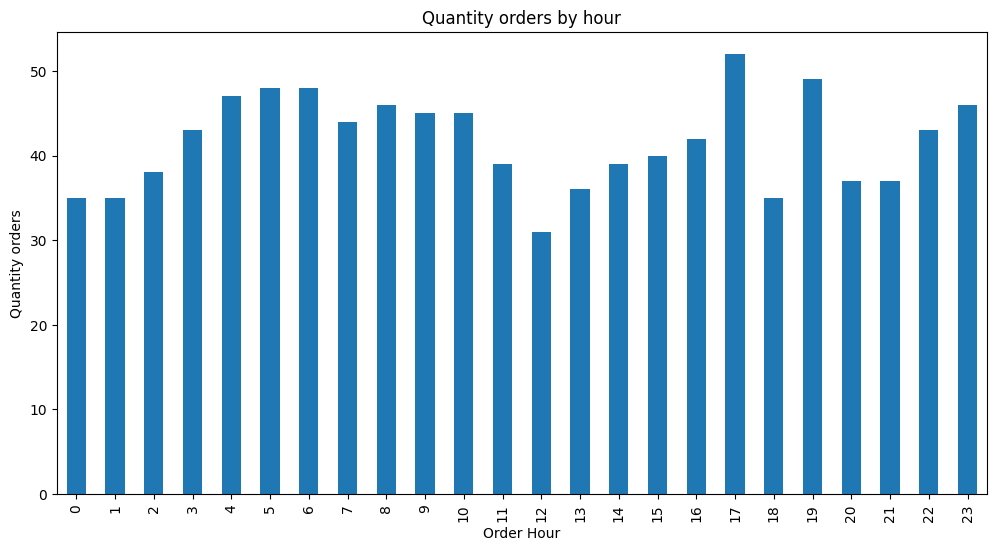

In [6]:
order_hour_counts = food_df['Order Hour'].value_counts().sort_index()
order_hour_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Order Hour')
plt.ylabel('Quantity orders')
plt.title('Quantity orders by hour')
plt.show()

We can see there is a spike of Orders at 17, delivery fee should also be higher at this point... Or not... Let's try to see it...

### Analysing Delivery Fees by hours

In [7]:
delivery_scaler = MinMaxScaler()

In [8]:
food_df['Scaled Delivery Fee'] = delivery_scaler.fit_transform(food_df[['Delivery Fee']])
food_df[['Delivery Fee', 'Scaled Delivery Fee']].head()

,Delivery Fee,Scaled Delivery Fee
0,0,0.0
1,40,0.8
2,30,0.6
3,50,1.0
4,30,0.6


<Axes: xlabel='Order Hour'>

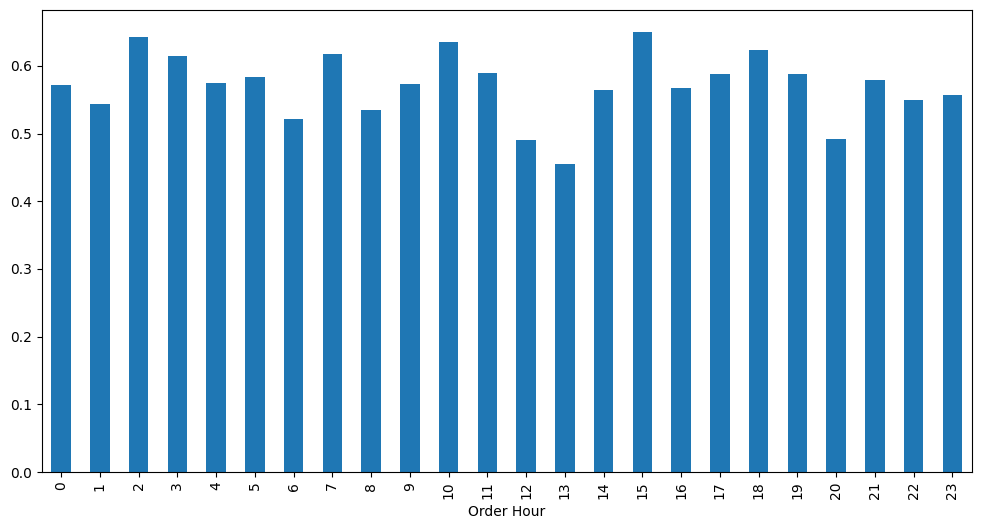

In [9]:
food_df.groupby('Order Hour')['Scaled Delivery Fee'].mean().plot(kind='bar', figsize=(12, 6))

As we see, there is no lineal correlation between delivery fee and quantity of orders by hours... Delivery fee spike at 15, this is probably because there are less delivery boys at this time working.<br>
Let's see how the Commission Fees behaves...

### Analysing Commission Fees by hours

In [10]:
commission_scaler = MinMaxScaler()

In [11]:
food_df['Scaled Commission Fee'] = commission_scaler.fit_transform(food_df[['Commission Fee']])
food_df[['Commission Fee', 'Scaled Commission Fee']].head()

,Commission Fee,Scaled Commission Fee
0,150,0.666667
1,198,0.986667
2,195,0.966667
3,146,0.640000
4,130,0.533333


<Axes: xlabel='Order Hour'>

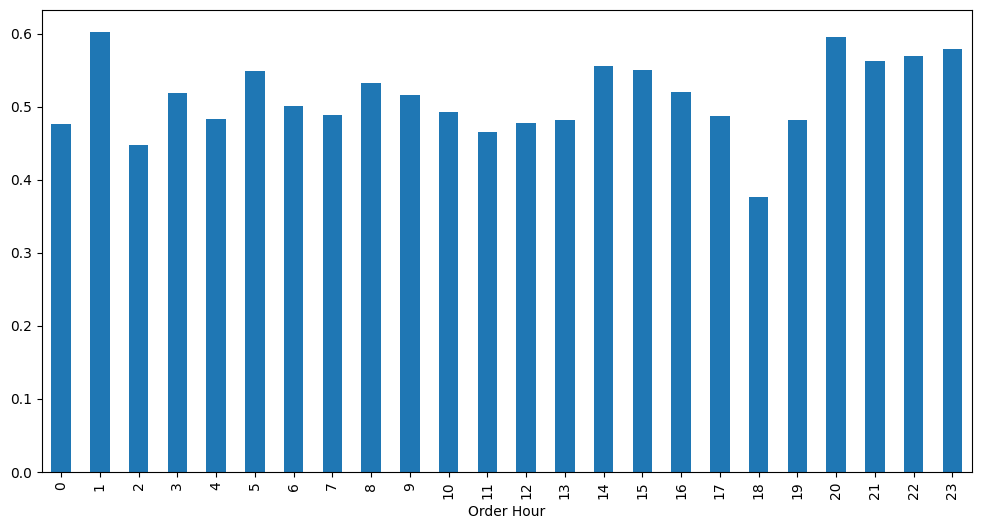

In [12]:
food_df.groupby('Order Hour')['Scaled Commission Fee'].mean().plot(kind='bar', figsize=(12, 6))

There is also no correlation, commission fees spike at 1 AM. <br>
Let's see now at what time does people order more expensive food and how they pay them.

### Analysing at which hour people do more expensive orders and how they are paid

In [13]:
order_scaler = MinMaxScaler()

In [14]:
food_df['Scaled Order Value'] = order_scaler.fit_transform(food_df[['Order Value']])
food_df[['Order Value', 'Scaled Order Value']].head()

,Order Value,Scaled Order Value
0,1914,0.957166
1,986,0.466420
2,937,0.440508
3,1463,0.718667
4,1992,0.998414


First let's see how people is more likely to pay...

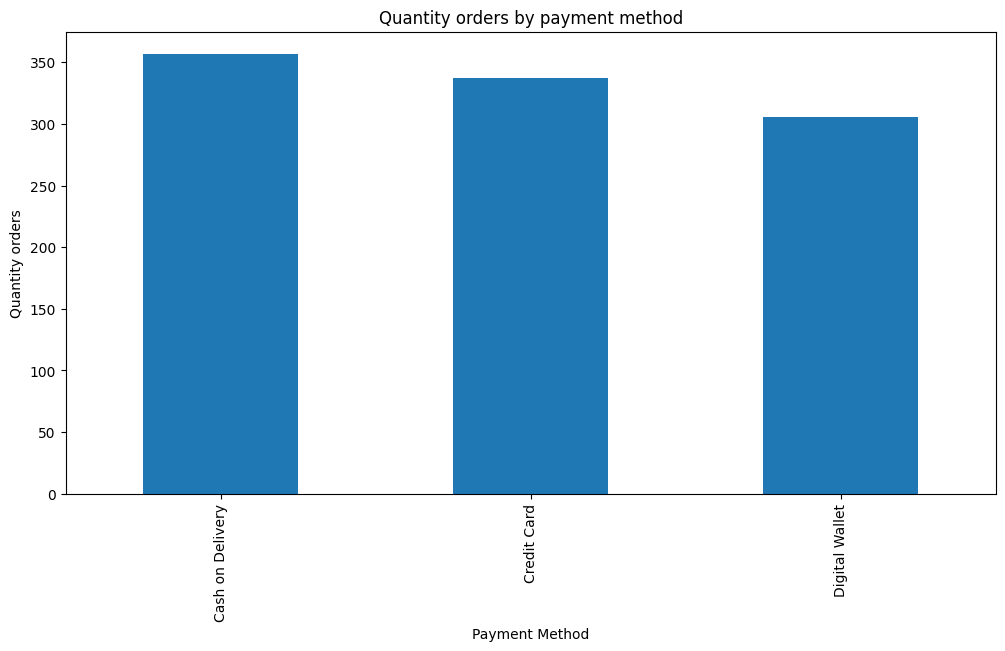

In [15]:
payment_methods_counts = food_df['Payment Method'].value_counts().sort_index()
payment_methods_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Payment Method')
plt.ylabel('Quantity orders')
plt.title('Quantity orders by payment method')
plt.show()

Ok, so people is more likely to pay the order on Cash

Let's see if this correlates in all hours or if there is an hour where people is more likely to use another payment method.

### Analysing payment methods by hour

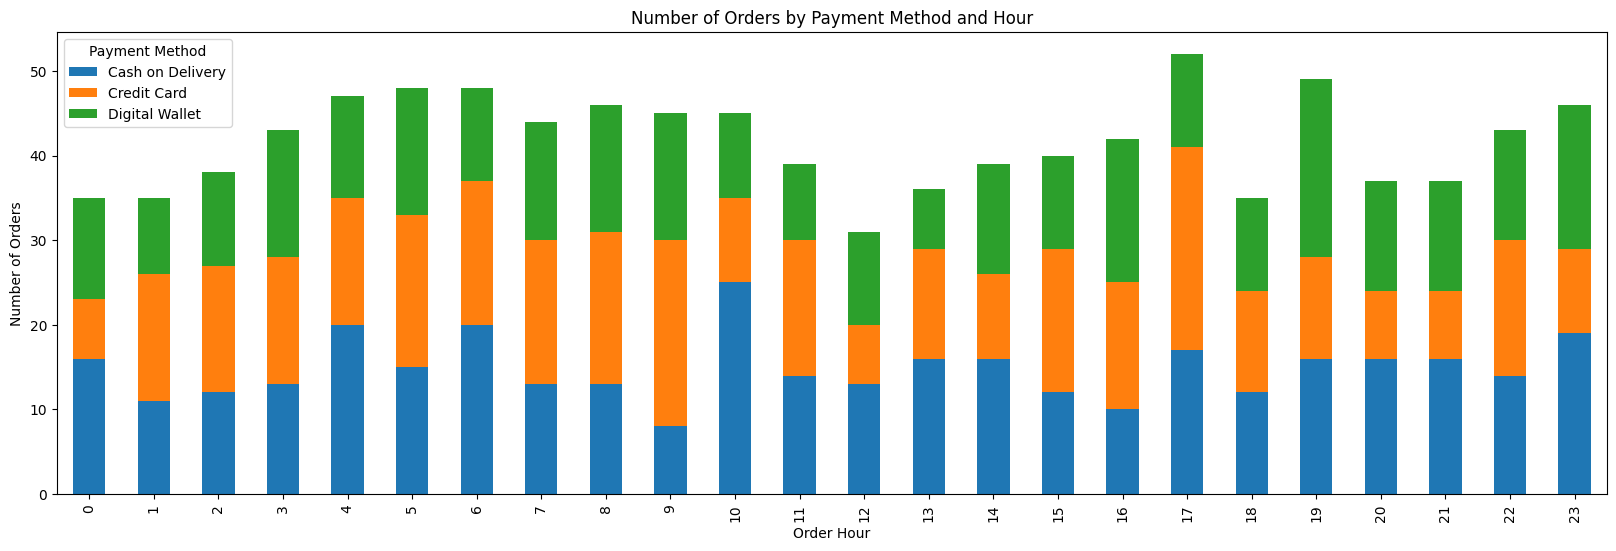

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
food_df.groupby(['Order Hour', 'Payment Method']).size().unstack().plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Order Hour')
ax.set_ylabel('Number of Orders')
ax.set_title('Number of Orders by Payment Method and Hour')
plt.show()

As we can see, for instance, at 9 AM and 5 PM people prefer to use their credit cards instead of cash.

### Analysing Order Value by Hour and Payment Methods

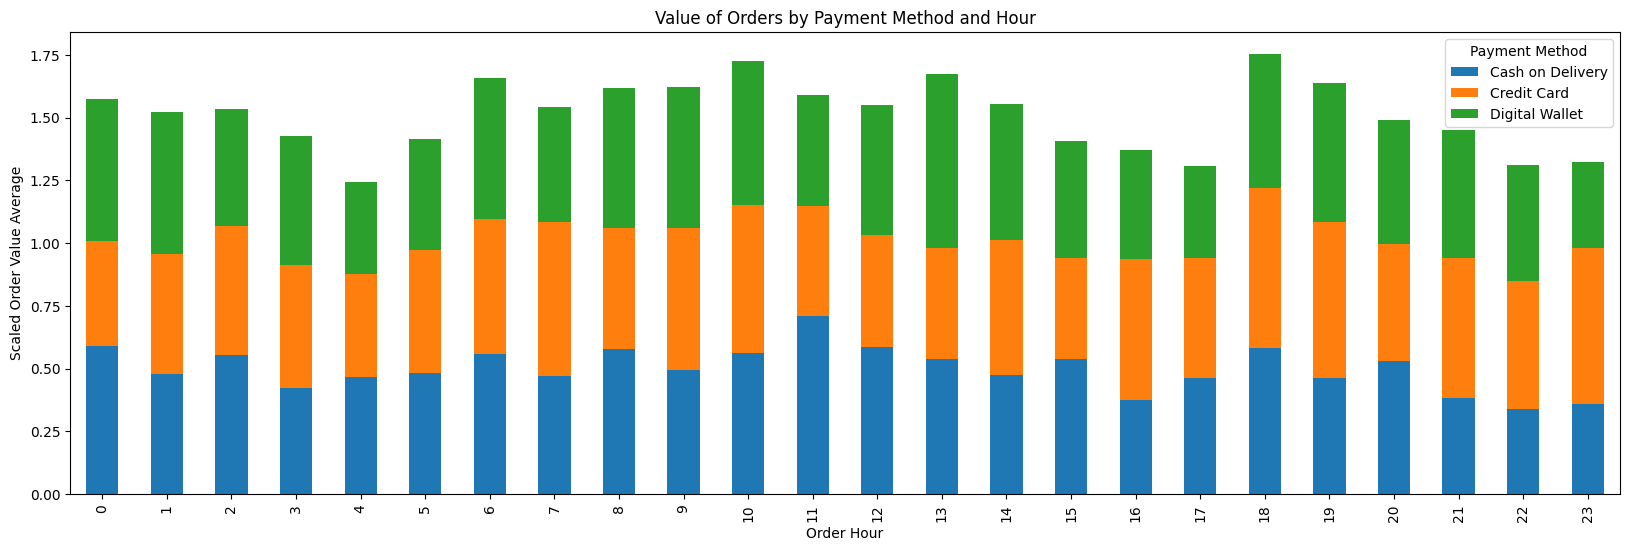

In [17]:
fig, ax = plt.subplots(figsize=(20, 6))
food_df.groupby(['Order Hour', 'Payment Method'])['Scaled Order Value'].mean().unstack().plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Order Hour')
ax.set_ylabel('Scaled Order Value Average')
ax.set_title('Value of Orders by Payment Method and Hour')
plt.show()


We can see on this graph that at 7 PM, 22 PM, 23 PM, people prefer to pay they orders using Credit Card instead of Cash on Delivery (Even though this is the overall method of payment)

### Most expensive Payment Method

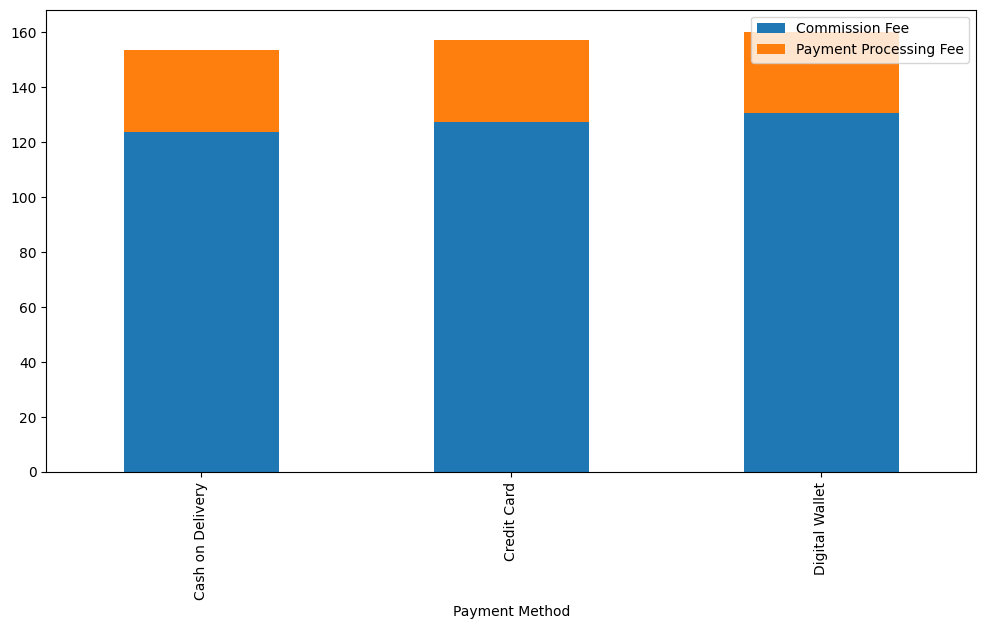

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
food_df.groupby('Payment Method')[['Commission Fee', 'Payment Processing Fee']].mean().plot(kind='bar', stacked=True, ax=ax)

plt.show()

As we can see here, is more expensive to use Digital Wallets for paying than other methods.

# Predicting Total Order Value

To predict the Total Order Value we will use the <b>Payment Method, the Discounts and Offers, the Order day of the Week and the order hour</b>

## Normalizing Discounts and Offers

In [19]:
distinct_discounts = food_df['Discounts and Offers'].dropna().unique()
distinct_discounts_count = len(distinct_discounts)
print(f"Distinct Discounts and Offers: {distinct_discounts}")

Distinct Discounts and Offers: ['5% on App' '10%' '15% New User' '50 off Promo']


In [20]:
# Create a mapping dictionary
discount_mapping = {
    '5% on App': 5,
    '10%': 10,
    '15% New User': 15,
    '50 off Promo': 50,
    np.nan: 0
}

# Apply the mapping to the 'Discounts and Offers' column
food_df['Normalized Discounts and Offers'] = food_df['Discounts and Offers'].replace(discount_mapping)
food_df[['Discounts and Offers', 'Normalized Discounts and Offers']].head()

/tmp/ipykernel_42979/2314475754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  food_df['Normalized Discounts and Offers'] = food_df['Discounts and Offers'].replace(discount_mapping)


,Discounts and Offers,Normalized Discounts and Offers
0,5% on App,5.0
1,10%,10.0
2,15% New User,15.0
3,NaN,0.0
4,50 off Promo,50.0


### Encoding Normalized Discounts and Offers

In [21]:
# Initialize the LabelEncoder
discounts_label_encoder = LabelEncoder()
food_df['Encoded Normalized Discounts and Offers'] = discounts_label_encoder.fit_transform(food_df['Discounts and Offers'])

# Display the first few rows to verify the encoding
food_df[['Normalized Discounts and Offers', 'Encoded Normalized Discounts and Offers']].head()


,Normalized Discounts and Offers,Encoded Normalized Discounts and Offers
0,5.0,2
1,10.0,0
2,15.0,1
3,0.0,4
4,50.0,3


### Encoding Payment Methods

In [22]:
# Initialize the LabelEncoder
payments_label_encoder = LabelEncoder()

# Fit and transform the 'Payment Method' column
food_df['Encoded Payment Method'] = payments_label_encoder.fit_transform(food_df['Payment Method'])

# Display the first few rows to verify the encoding
food_df[['Payment Method', 'Encoded Payment Method']].head()

,Payment Method,Encoded Payment Method
0,Credit Card,1
1,Digital Wallet,2
2,Cash on Delivery,0
3,Cash on Delivery,0
4,Cash on Delivery,0


### Getting Total Order Value

In [23]:
food_df['Total Order Value']=food_df['Order Value']+food_df['Delivery Fee']+food_df['Commission Fee']+food_df['Payment Processing Fee']
food_df['Total Order Value'].head()

0    2111
1    1247
2    1207
3    1686
4    2202
Name: Total Order Value, dtype: int64

### Scaling Total Order Value

In [24]:
total_scaler = MinMaxScaler()
food_df['Scaled Total Order Value']=total_scaler.fit_transform(food_df[['Total Order Value']])

### Getting day of the week the order was made

In [25]:
food_df['Order Day of Week'] = food_df['Order Date and Time'].dt.dayofweek
food_df[['Order Date and Time', 'Order Day of Week']].head()

,Order Date and Time,Order Day of Week
0,2024-02-01 01:11:52,3
1,2024-02-02 22:11:04,4
2,2024-01-31 05:54:35,2
3,2024-01-16 22:52:49,1
4,2024-01-29 01:19:30,0


### Defining Data (X) and Target (y)

In [26]:
data=food_df[['Order Day of Week', 'Order Hour', 'Scaled Order Value', 'Encoded Payment Method', 'Encoded Normalized Discounts and Offers']]
target=food_df['Scaled Total Order Value']

In [27]:
data.head()

,Order Day of Week,Order Hour,Scaled Order Value,Encoded Payment Method,Encoded Normalized Discounts and Offers
0,3,1,0.957166,1,2
1,4,22,0.466420,2,0
2,2,5,0.440508,0,1
3,1,22,0.718667,0,4
4,0,1,0.998414,0,3


In [28]:
target.head()

0    0.944640
1    0.509814
2    0.489683
3    0.730750
4    0.990438
Name: Scaled Total Order Value, dtype: float64

### Split Train-Test-Validation Data and Target

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Creating the Model

In [30]:
# Define the RNN model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print the model summary
model.summary()

# Reshape the input data to be 3D [samples, timesteps, features]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))



I0000 00:00:1728596482.707025   42979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596482.935610   42979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596482.936138   42979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596482.940989   42979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596482.941511   42979 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1728596485.189290   43081 service.cc:146] XLA service 0x7fb3f80cfe00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728596485.189339   43081 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-10-10 18:41:25.214133: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 18:41:25.371291: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8900


23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3405

I0000 00:00:1728596485.879338   43081 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3273 - val_loss: 0.1218
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1159 - val_loss: 0.0844
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0976 - val_loss: 0.0701
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0819 - val_loss: 0.0598
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0643 - val_loss: 0.0556
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - val_loss: 0.0487
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0506 - val_loss: 0.0432
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - val_loss: 0.0313
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0338 - val_loss: 0.0216
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0163
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_loss: 0.0143
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - val_loss: 0.0129

### Making predictions with the Model

In [31]:
# Reshape X_test to be 3D [samples, timesteps, features]
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict using the model
y_pred = model.predict(X_test_reshaped)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


### Comparing predictions with actual test data

In [32]:
# Transform y_test and y_pred back to their original scale
y_test_original = total_scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_original = total_scaler.inverse_transform(y_pred)

# Compare the transformed predictions with the actual values
comparison_df_original = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': y_pred_original.flatten()})
print(comparison_df_original)

    Actual    Predicted
0   1479.0  1450.941284
1   1268.0  1231.555786
2   1215.0  1247.713379
3   1059.0   994.018982
4    728.0   644.382324
..     ...          ...
95  1994.0  1881.523438
96  1176.0  1172.251465
97  1566.0  1456.160645
98  1502.0  1478.810913
99   951.0   822.780396

[100 rows x 2 columns]


## Plotting Total Order Value Prediction vs Actual Order Value 

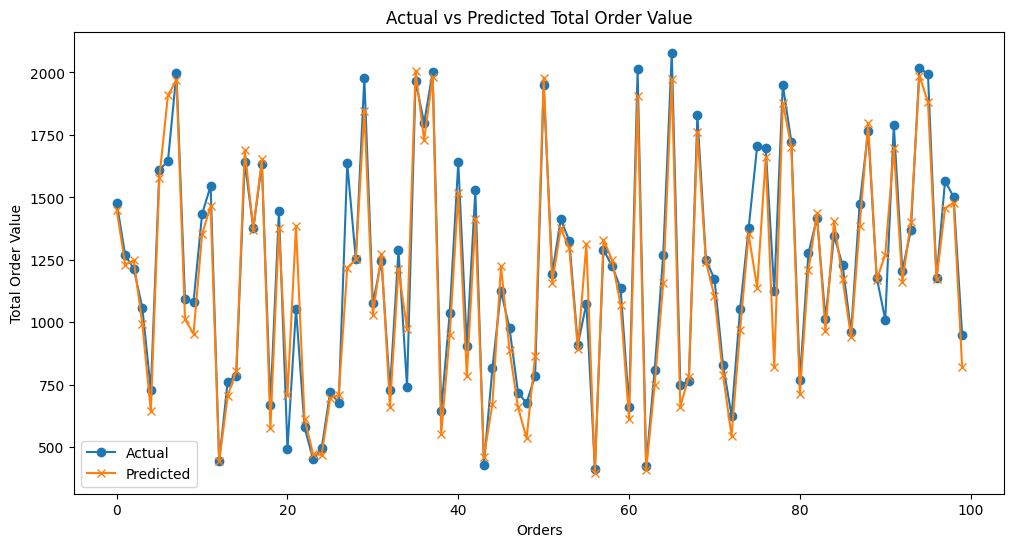

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df_original['Actual'], label='Actual', marker='o')
plt.plot(comparison_df_original['Predicted'], label='Predicted', marker='x')
plt.xlabel('Orders')
plt.ylabel('Total Order Value')
plt.title('Actual vs Predicted Total Order Value')
plt.legend()
plt.show()

# Conclusion

In this notebook, we performed an extensive analysis and prediction of food delivery orders in New Delhi. Here are the key steps and findings:

1. **Data Preprocessing**:
    - We imported the necessary libraries and loaded the dataset.
    - We converted date and time columns to datetime objects and extracted useful features such as order and delivery hours.
    - We normalized various numerical features like delivery fee, commission fee, and order value using MinMaxScaler.
    - We encoded categorical features such as payment methods and discounts using LabelEncoder.

2. **Exploratory Data Analysis (EDA)**:
    - We visualized the distribution of orders by hour and found a spike at 17:00.
    - We analyzed the delivery fee and commission fee by hour and found no linear correlation with the quantity of orders.
    - We examined payment methods and found that cash on delivery is the most popular method, but preferences vary by hour.
    - We identified that digital wallets are the most expensive payment method due to higher commission and processing fees.

3. **Feature Engineering**:
    - We created new features such as normalized discounts and total order value.
    - We prepared the data for modeling by selecting relevant features and splitting the dataset into training, validation, and test sets.

4. **Modeling**:
    - We built and trained an LSTM model to predict the total order value based on features like order hour, payment method, and discounts.
    - We evaluated the model's performance and compared the predicted values with the actual values.

5. **Results**:
    - The model showed a reasonable performance in predicting the total order value.
    - We visualized the actual vs. predicted total order values and observed that the model captures the trend well, although there are some deviations.